In [64]:
import tensorflow as tf
from tensorflow.keras import layers
import chess
import numpy as np


In [65]:
def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    isWhite = parts[1] == 'w'
    
    binary_board = np.zeros((8, 8, 6), dtype=np.float32)
    piece_amount = np.zeros((12), dtype=np.float32)
    pieces = {'p': [0, 1.0], 'r': [1, 1.0], 'n': [2, 1.0], 'b': [3, 1.0], 'q': [4, 1.0], 'k': [5, 1.0],
              'P': [0, -1.0], 'R': [1, -1.0], 'N': [2, -1.0], 'B': [3, -1.0], 'Q': [4, -1.0], 'K': [5, -1.0]}
    

    rows = board_part.split('/')
    for j, row in enumerate(rows):
        col = 0
        for piece in row:
            if piece.isdigit():
                # Empty squares
                col += int(piece)
            else:
                i = j*8+col
                if isWhite:
                    binary_board[i // 8, i % 8, pieces[str(piece)][0]] = pieces[str(piece)][1] 
                else:
                    binary_board[7-(i // 8), 7-(i % 8), pieces[str(piece)][0]] = -pieces[str(piece)][1]
                if isWhite ^ (pieces[str(piece)][1] < 0):
                    piece_amount[pieces[str(piece)][0]] += 1
                else:
                    piece_amount[pieces[str(piece)][0]+6] += 1


    return [binary_board, piece_amount]


In [66]:
main_input = tf.keras.Input(shape=(8, 8, 6), name='main_input')
auxiliary_input = tf.keras.Input(shape=(12), name='auxiliary_input')

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(main_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(x)

x = layers.Flatten()(x)
merged_input = layers.concatenate([x, auxiliary_input])

x = layers.Dense(256, activation='relu')(merged_input)
# x = layers.Dropout(0.5)(x)

output = layers.Dense(1)(x)

model = tf.keras.Model(inputs=[main_input, auxiliary_input], outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])



In [67]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 8, 8, 6)]            0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 8, 8, 8)              440       ['main_input[0][0]']          
                                                                                                  
 max_pooling2d_21 (MaxPooli  (None, 4, 4, 8)              0         ['conv2d_28[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 4, 4, 16)             1168      ['max_pooling2d_21[0][0]

In [68]:
import random
with open(r'akimbo-2085723380.epd', 'r') as f:
    lines = f.readlines()

random.shuffle(lines)
fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [-float(line.split()[-3]) if line.split()[1] == 'b' else float(line.split()[-3]) for line in lines]

# Separate the components into two arrays
binary_boards = []
piece_amounts = []

for fen in fens:
    binary_board, piece_amount = fen_to_board(fen)
    binary_boards.append(binary_board)
    piece_amounts.append(piece_amount)

binary_boards = np.array(binary_boards)
piece_amounts = np.array(piece_amounts)
ratings = np.array(ratings)


In [69]:
train_size = int(len(binary_boards) * 0.8)
val_size = int(len(binary_boards) * 0.10)

# Separate binary boards and piece amounts
x_binary_train, x_piece_train, y_train = binary_boards[:train_size], piece_amounts[:train_size], ratings[:train_size]
x_binary_val, x_piece_val, y_val = binary_boards[train_size:train_size + val_size], piece_amounts[train_size:train_size + val_size], ratings[train_size:train_size + val_size]
x_binary_test, x_piece_test, y_test = binary_boards[train_size + val_size:], piece_amounts[train_size + val_size:], ratings[train_size + val_size:]


In [70]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    [x_binary_train, x_piece_train],
    y_train,
    validation_data=([x_binary_val, x_piece_val], y_val),
    batch_size=64,
    epochs=100, 
    callbacks=[early_stopping]
)


Epoch 1/100
35530/35530 [==============================] - 333s 9ms/step - loss: 79914.3516 - mae: 211.6223 - val_loss: 60256.2109 - val_mae: 185.1272
Epoch 2/100
35530/35530 [==============================] - 332s 9ms/step - loss: 57890.3164 - mae: 179.4152 - val_loss: 56605.3398 - val_mae: 177.9188
Epoch 3/100
35530/35530 [==============================] - 333s 9ms/step - loss: 55479.9727 - mae: 174.9012 - val_loss: 55191.0625 - val_mae: 176.3337
Epoch 4/100
35530/35530 [==============================] - 335s 9ms/step - loss: 54187.2617 - mae: 172.3897 - val_loss: 55118.7656 - val_mae: 175.0705
Epoch 5/100
35530/35530 [==============================] - 340s 10ms/step - loss: 53347.5820 - mae: 170.7349 - val_loss: 53760.5117 - val_mae: 172.5918
Epoch 6/100
35530/35530 [==============================] - 342s 10ms/step - loss: 52768.5938 - mae: 169.6263 - val_loss: 53728.5352 - val_mae: 173.3145
Epoch 7/100
35530/35530 [==============================] - 342s 10ms/step - loss: 52332.1172

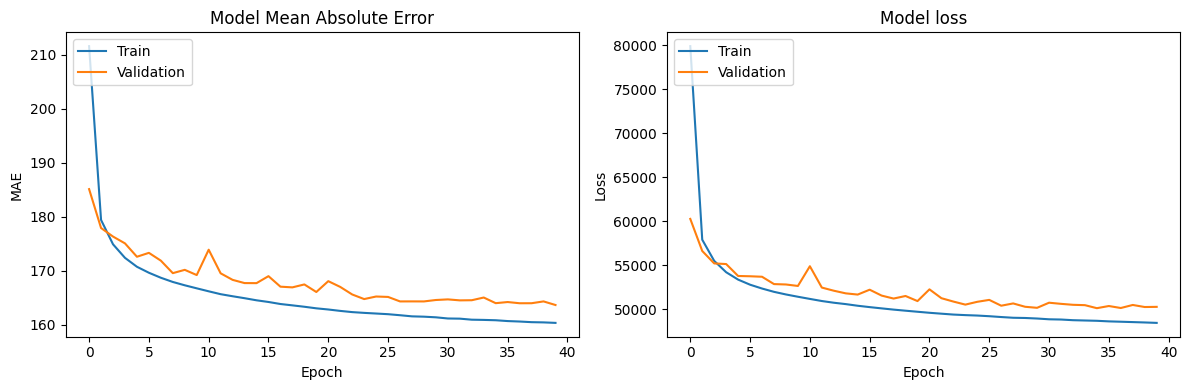

In [71]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])  
plt.plot(history.history['val_mae']) 
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [72]:
model.save('TrainedModel2.keras')

94/94 [==============================] - 1s 5ms/step


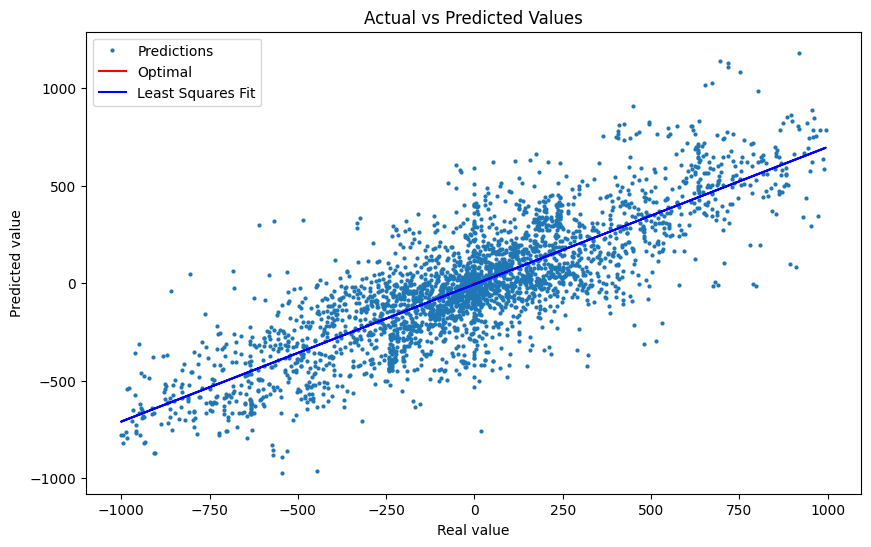

Predicted rating: [126.75954], True rating: -163.0
Predicted rating: [-198.23056], True rating: 104.0


In [73]:
import matplotlib.pyplot as plt
import numpy as np

x_test = [x_binary_test[:3000], x_piece_test[:3000]]
# Predict the ratings for the test data
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.plot(y_test[:3000], y_pred, marker='o', linestyle='None', markersize=2.0, label='Predictions')

# Line x=y for perfect predictions
plt.plot([-1, 1], [-1, 1], color='red', label='Optimal')

# Least squares fit line
coeff = np.polyfit(y_test[:3000].flatten(), y_pred.flatten(), 1)
fit_line = np.polyval(coeff, y_test[:3000].flatten())
plt.plot(y_test[:3000], fit_line, color='blue', label='Least Squares Fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()

# Print the predicted and true ratings for the test data
for i in range(min(len(x_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")
